In [1]:
## Author: Aloi Davide - PhD student - University of Birmingham 
# Data: MRI (T1s) scans with different brain tumors, downloaded from
# https://figshare.com/articles/dataset/brain_tumor_dataset/1512427. 
# There are 3 types of tumors: 1 for meningioma, 2 for glioma, 3 for pituitary tumor.
# Files are in .mat format so we'll have to use mat73 to read their content. 
# 

## Healthy MRI scans, still not used
# Healthy MRI scans http://brain-development.org/ixi-dataset/

import os 
import nilearn
import scipy
from fastai.vision.all import *
import mat73 

# Path to the tumor dataset in .mat format
path = os.path.join('D:\\deep_learning_project\\project\\tumor_dataset\\dataset')
path

'D:\\deep_learning_project\\project\\tumor_dataset\\dataset'

In [ ]:
# SKIP THIS IF YOU HAVE EXTRACTED THE MAT FILES ALREADY
from PIL import Image
# Extracting and 
# displaying some info about the dataset 
PIDs = []
tumor_type = []
for file in os.listdir(path):
    data = mat73.loadmat(os.path.join(path,file))
    im = Image.fromarray((data['cjdata']['image']/data['cjdata']['image'].max()) * 255)

    if int(data['cjdata']['label']) == 1:
        label = 'meningioma'
    elif int(data['cjdata']['label']) == 2:
        label = 'glioma'
    else:
        label = 'pituitary'


    im = im.convert('P')
    im.save(os.path.join('data', label,file.split('.')[0] + '.png'))
    
    if not data['cjdata']['PID'] in PIDs:
        PIDs.append(data['cjdata']['PID'])
        tumor_type.append(int(data['cjdata']['label']))

import matplotlib.pyplot as plt
print(f'There are {len(PIDs)} patients with brain tumors in the dataset.')
print(f'{tumor_type.count(1)} are meningiomas, {tumor_type.count(2)} are gliomas, {tumor_type.count(3)} are pituitary tumors.')

fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
plt.bar(['Meningiomas', 'Gliomas', 'Pituitary tumor'],
        [tumor_type.count(1), tumor_type.count(2), tumor_type.count(3)])
plt.ylabel('Patients')
plt.show()

In [2]:
def pathology(x): return str(get_image_files(x)[0]).split('\\')[-2]
path_images = os.path.join('C:\\Users\\davide\\Documents\\GitHub\\idmlp_project\\data\\')
path_images

'C:\\Users\\davide\\Documents\\GitHub\\idmlp_project\\data\\'

In [3]:
data = ImageDataLoaders.from_folder(path_images, valid_pct=0.2, size=224)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


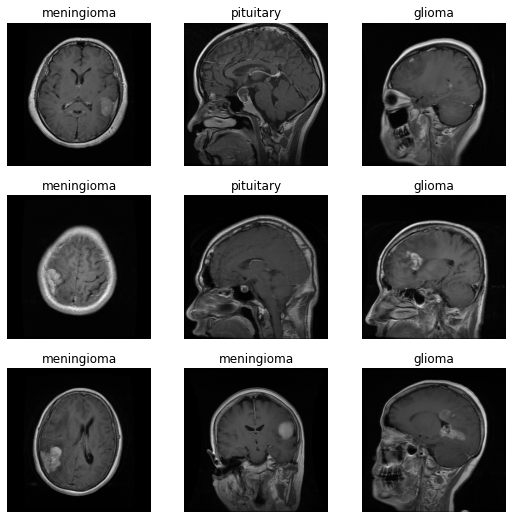

In [5]:
data.show_batch()

In [6]:
learn = cnn_learner(data, resnet34, metrics=error_rate)
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,2.080130,2.166323,0.675676,02:28


epoch,train_loss,valid_loss,error_rate,time
0,1.109637,1.207198,0.540541,03:18


In [15]:
learn.save('model')

Path('C:/Users/davide/Documents/GitHub/idmlp_project/data/models/model.pth')

In [15]:
img = PILImage.create(os.path.join(path_images,'pituitary','1260.png'))


pathology,_,probs = learn.predict(img)
print(f"Pathology identified: {pathology}.")
#print(f"Probability it's a tumor: {probs[1].item():.6f}")

Pathology identified: pituitary.
